-------------------------------------------------------------------------------
# Import Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE)
BACKCOLOR = '#f6f5f5'

from IPython.core.display import HTML

In [3]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [6]:
train = pd.read_csv("../input/spaceship-titanic/train.csv")
test = pd.read_csv("../input/spaceship-titanic/test.csv")
submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

In [7]:
all_data.head(10).style.background_gradient()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.000000,False,0.000000,483.000000,0.000000,291.000000,0.000000,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.000000,False,42.000000,1539.000000,3.000000,0.000000,0.000000,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.000000,False,0.000000,0.000000,0.000000,0.000000,nan,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.000000,False,0.000000,785.000000,17.000000,216.000000,0.000000,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Erraiam Flatic,True


In [8]:
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 8693 x 14
test size : 4277 x 13
total size : 12970 x 14


-------------------------------------------------------------------------------
## 2. Description🔎  
When I start the EDA, I first check the description of each variable to see if there are any types and measurements.

|Variable|Definition|
|------|---|
|PassengerId|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.||
|HomePlanet|The planet the passenger departed from, typically their planet of permanent residence.|
|CryoSleep|Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.HomePlanet||
|Cabin|The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.||
|Destination|The planet the passenger will be debarking to.||
|Age|The age of the passenger.||
|VIP|Whether the passenger has paid for special VIP service during the voyage.||
|RoomService, FoodCourt, ShoppingMall, Spa, VRDeck|Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.||
|Name|The first and last names of the passenger.||
|Transported|Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.||

In [9]:
all_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [10]:
all_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [12]:
all_data.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [13]:
multi_table([pd.DataFrame(all_data[i].value_counts()) for i in all_data.columns if i != 'Age'])

,PassengerId
0001_01,1
9227_03,1
9220_01,1
9220_02,1
9220_03,1
...,...
4610_01,1
4611_01,1
4612_01,1
4613_01,1


If you look at it so far, you can see exactly which variables are nominal and which are continuous.
Additional basic statistics can be found for numeric variables. I checked the statistics of the training data, the test data, and the total data.

In [14]:
nominal_vars = ['HomePlanet', 'CryoSleep', 'Cabin', 'Desination', 'VIP', 'Name']
continuous_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
target = 'Transported'

In [15]:
train_st = train[continuous_vars].describe()
test_st = test[continuous_vars].describe()
all_st = all_data[continuous_vars].describe()
multi_table([all_st, train_st, test_st])

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000
,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000


<AxesSubplot:>

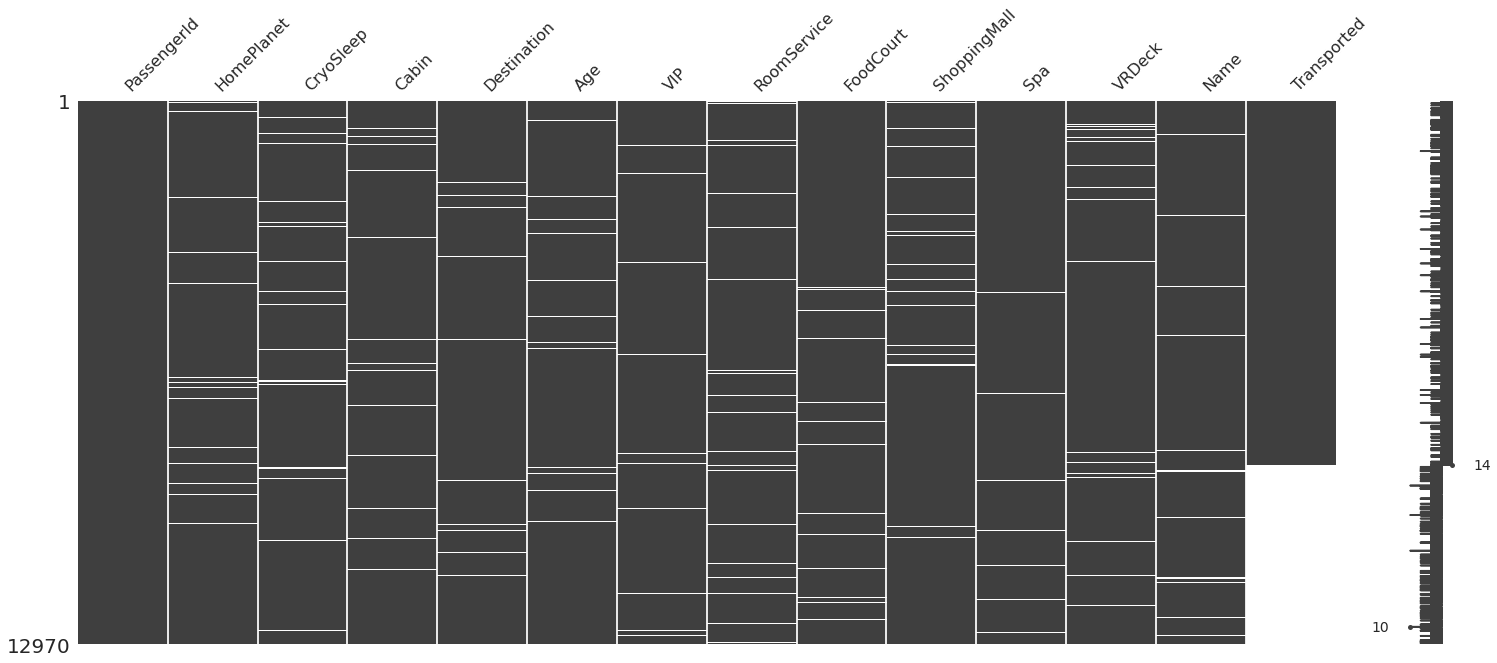

In [16]:
import missingno as msno
msno.matrix(all_data)

<AxesSubplot:>

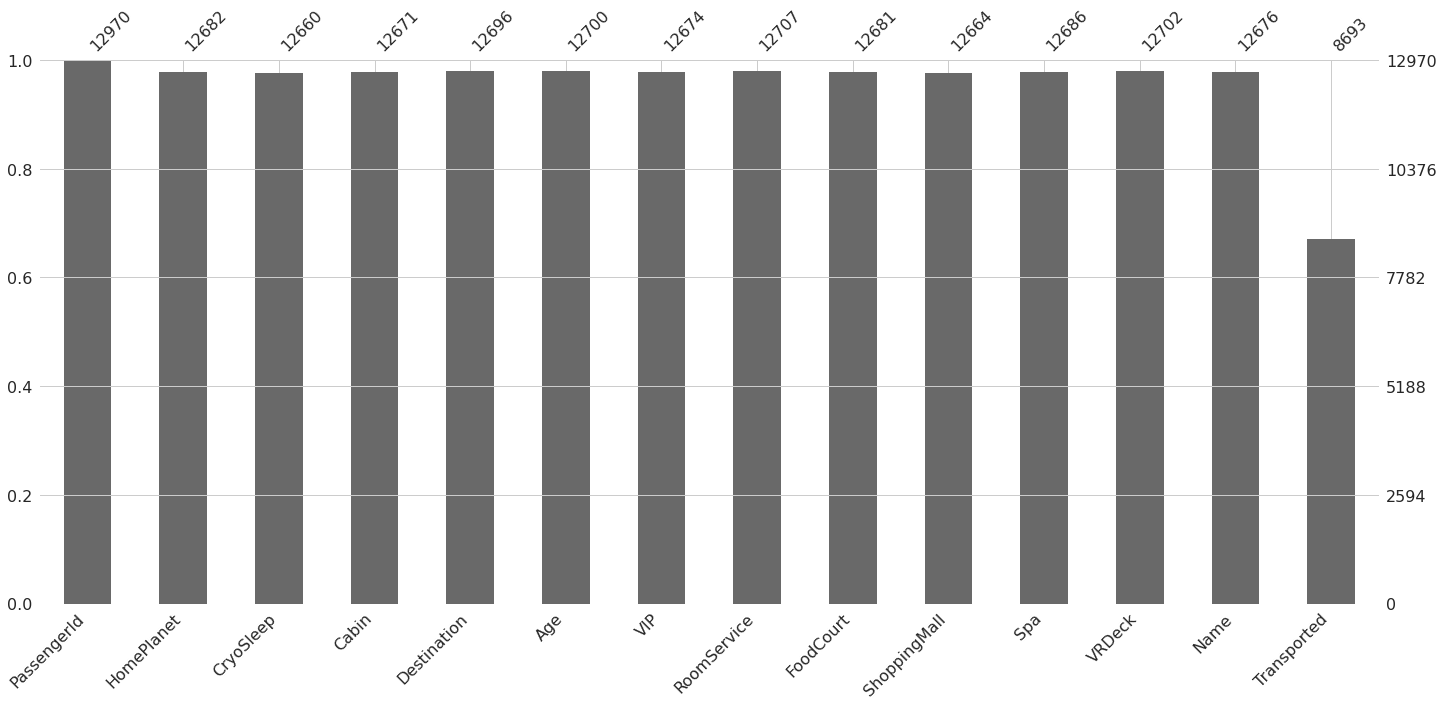

In [17]:
msno.bar(all_data)

<div class="alert alert-block alert-info">
<span style="color:red">🔑conclusion</span>:    
  
Most variables have missing values. We must solve this problem. The missing value processing methods are broadly divided into the following:  
  
1. Remove missing values  
2. Replacement of missing values  
  
I prefer alternative methods to removal methods. This is because information loss can occur. A good way to replace it is to replace continuous variables with mean, median, and categorical variables with most free values. Another method is to understand why missing values of variables occur and replace them directly with specific values. For example, the missing value of the Shopping Mall is likely to be paid for, so I can replace it with zero.I will then proceed with this task in the preprocessing part.
</div>

-------------------------------------------------------------------------------
### HomePlanet (Nominal)  
These variables are nominal variables, so we decided to check the distribution with countplot. To see if this variable can explain the dependent variable well, we checked the distribution of the dependent variable again. I confirmed the following results.

1) Among the Homeplanets, 54.19% of the earth's share is the highest.  
2) The ratio of Europa to Mars is almost the same.  
3) Among Europa, the percentage of Transported is certainly high.  
4) The false percentage of Transported in Earth is certainly high.  
5) There is not much difference in Transported among Mars.

= > More than half of people belong to Earth. In addition, the difference between Earth and Europa's transported ratio is certain, so the sorting algorithm can work well. Therefore, you will be able to use the variable well to solve this problem.

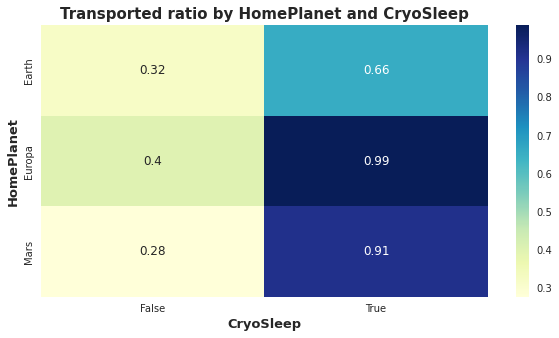

In [28]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='CryoSleep', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and CryoSleep', weight='bold', size=15)
g.set_xlabel('CryoSleep', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

<div class="alert alert-block alert-info">
<span style="color:red">🔑conclusion</span>:   
Passengers in suspended sleep are generally likely to be transmitted. Especially in Europa and Mars, most passengers during housekeeping sleep were forwarded.
</div>

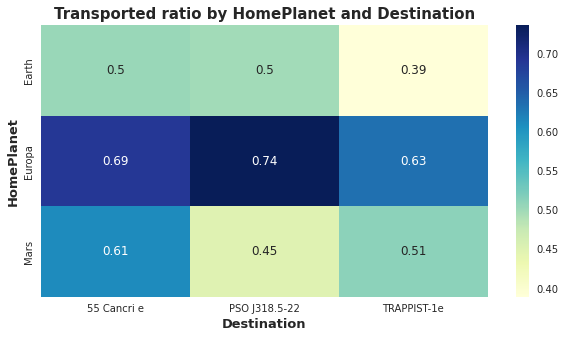

In [29]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.Destination, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

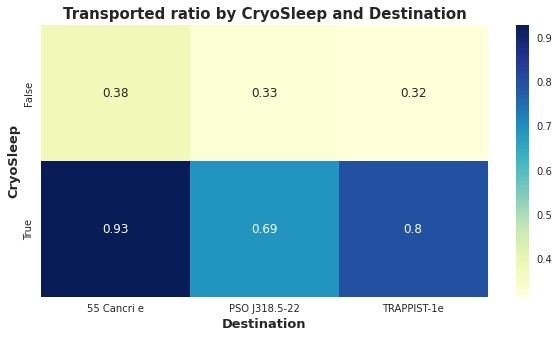

In [30]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='CryoSleep', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by CryoSleep and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('CryoSleep', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.Destination,margins=True).style.background_gradient()

<div class="alert alert-block alert-info">
<span style="color:red">🔑conclusion</span>:   
Most passengers who are in a suspended sleep have been transferred out of the 55 Cancrie destinations.
</div>

### Imputing Missing values

In [31]:
# Replace categorical variables with specific values (False, None) or freeest values.
all_data['CryoSleep'].fillna(False, inplace=True)
all_data['Cabin'].fillna('None', inplace=True)
all_data['VIP'].fillna(all_data.VIP.mode()[0], inplace=True)
all_data['HomePlanet'].fillna(all_data.HomePlanet.mode()[0], inplace=True)
all_data['Destination'].fillna(all_data.Destination.mode()[0], inplace=True)

# Replace continuous variables with specific values (0) or averages.
all_data['Age'].fillna(all_data.Age.mean(), inplace=True)
all_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] =\
all_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

-------------------------------------------------------------------------------
### Create Derivative variable

In [32]:
# As mentioned earlier, create a new variable by decomposing strings in Cabin and PassengerId.
all_data['Deck'] = all_data.Cabin.apply(lambda x:str(x)[:1])
all_data['Side'] = all_data.Cabin.apply(lambda x:str(x)[-1:])
all_data['PassengerGroup'] = all_data['PassengerId'].apply(lambda x: x.split('_')[0])
all_data['PassengerNo'] = all_data['PassengerId'].apply(lambda x: x.split('_')[1])

# Generate new variables based on the amount of money used for various services.
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data['Spa'] + all_data['VRDeck']
all_data['PctRoomService'] = all_data['RoomService']/all_data['TotalSpend']
all_data['PctFoodCourt'] = all_data['FoodCourt']/all_data['TotalSpend']
all_data['PctShoppingMall'] = all_data['ShoppingMall']/all_data['TotalSpend']
all_data['PctSpa'] = all_data['Spa']/all_data['TotalSpend']
all_data['PctVRDeck'] = all_data['VRDeck']/all_data['TotalSpend']

# Create new variables by dividing age groups.
all_data['AgeBin'] = 7
for i in range(6):
    all_data.loc[(all_data.Age >= 10*i) & (all_data.Age < 10*(i + 1)), 'AgeBin'] = i

In [33]:
# Replaces the missing value that occurred when generating the derived variable.
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
all_data[fill_cols] = all_data[fill_cols].fillna(0)

### Drop Variables

In [34]:
# Remove unnecessary variables.
all_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [35]:
for col in all_data.columns[all_data.dtypes == object]:
    if col != 'Transported':
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col])
        
all_data['CryoSleep'] = all_data['CryoSleep'].astype('int')
all_data['VIP'] = all_data['VIP'].astype('int')

### Split Train / Test

In [36]:
train, X_test = all_data.iloc[:train.shape[0]], all_data.iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [37]:
s = setup(data=train,
          session_id=7010,
          target='Transported',
          train_size=0.99,
          fold_strategy='stratifiedkfold',
          fold=5,
          fold_shuffle=True,
          silent=True,
          ignore_low_variance=True,
          remove_multicollinearity = True,
          normalize = True,
          normalize_method = 'robust',)

,Description,Value
0,session_id,7010
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(8693, 22)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


Compare_model allows you to compare the results of learning given data by model. I checked the top four models.

In [38]:
top4 = compare_models(n_select=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8164,0.9055,0.8222,0.8148,0.8184,0.6328,0.6330,7.8460
lightgbm,Light Gradient Boosting Machine,0.8076,0.8998,0.8141,0.8058,0.8098,0.6151,0.6154,0.3740
xgboost,Extreme Gradient Boosting,0.8071,0.8938,0.7993,0.8140,0.8065,0.6143,0.6146,2.8120
gbc,Gradient Boosting Classifier,0.8011,0.8949,0.8360,0.7833,0.8087,0.6020,0.6035,1.2840
rf,Random Forest Classifier,0.7968,0.8815,0.7716,0.8146,0.7924,0.5937,0.5946,1.1020
ada,Ada Boost Classifier,0.7963,0.8777,0.8418,0.7736,0.8061,0.5924,0.5950,0.3920
lr,Logistic Regression,0.7935,0.8800,0.8293,0.7758,0.8016,0.5868,0.5883,1.4180
et,Extra Trees Classifier,0.7912,0.8645,0.7607,0.8124,0.7856,0.5825,0.5839,1.1180
ridge,Ridge Classifier,0.7898,0.0000,0.8506,0.7603,0.8028,0.5793,0.5836,0.0460
lda,Linear Discriminant Analysis,0.7898,0.8739,0.8506,0.7603,0.8028,0.5793,0.5836,0.0840


In [39]:
print(top4[0])

The best model is Catboost. I have been optimizing Catboost models in various ways, and I have also evaluated the performance of models with the top four models as ensemble.

In [40]:
!pip install scikit-optimize
!pip install tune-sklearn ray[tune]
import optuna
!pip install hpbandster ConfigSpace

     |████████████████████████████████| 41 kB 67 kB/s             
     |████████████████████████████████| 59.1 MB 39.0 MB/s            
     |████████████████████████████████| 8.8 MB 52.0 MB/s            
     |████████████████████████████████| 468 kB 54.6 MB/s            
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 2.3.0
    Uninstalling platformdirs-2.3.0:
      Successfully uninstalled platformdirs-2.3.0
  Attempting uninstall: ray
    Found existing installation: ray 1.10.0
    Uninstalling ray-1.10.0:
      Successfully uninstalled ray-1.10.0
     |████████████████████████████████| 51 kB 84 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.9 MB 1.6 MB/s            
     |████████████████████████████████| 89 kB 7.2 MB/s             
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80007 sha256=704d5b6582b33049aa338aaac4110de32a87e51284a348e0eadac5d1acae231b
  St

The following model is the best model I obtained while tuning myself using the annotation code below. I hope you can refer to it. If you derive results after learning in this model, you can get a score of about 0.8097.

In [41]:
catboost_best = create_model('catboost', nan_mode= 'Min',
                         eval_metric='Logloss',
                         iterations=1000,
                         sampling_frequency='PerTree',
                         leaf_estimation_method='Newton',
                         grow_policy='SymmetricTree',
                         penalties_coefficient=1,
                         boosting_type='Plain',
                         model_shrink_mode='Constant',
                         feature_border_type='GreedyLogSum',                        
                         l2_leaf_reg=3,
                         random_strength=1, 
                         rsm=1, 
                         boost_from_average=False,
                         model_size_reg=0.5, 
                         subsample=0.800000011920929, 
                         use_best_model=False, 
                         class_names=[0, 1],
                         depth=6, 
                         posterior_sampling=False, 
                         border_count=254, 
                         classes_count=0, 
                         auto_class_weights='None',
                         sparse_features_conflict_fraction=0, 
                         leaf_estimation_backtracking='AnyImprovement',
                         best_model_min_trees=1, 
                         model_shrink_rate=0, 
                         min_data_in_leaf=1, 
                         loss_function='Logloss',
                         learning_rate=0.02582800015807152,
                         score_function='Cosine',
                         task_type='CPU',
                         leaf_estimation_iterations=10, 
                         bootstrap_type='MVS',
                         max_leaves=64)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8084,0.8999,0.8002,0.8153,0.8077,0.6168,0.6169
1,0.8222,0.9121,0.8395,0.8132,0.8261,0.6443,0.6446
2,0.8181,0.8998,0.8083,0.8264,0.8173,0.6363,0.6364
3,0.8030,0.9013,0.8199,0.7951,0.8073,0.6059,0.6062
4,0.8280,0.9149,0.8349,0.8253,0.8301,0.6560,0.6560
Mean,0.8159,0.9056,0.8206,0.8151,0.8177,0.6319,0.6320
Std,0.0091,0.0065,0.0150,0.0113,0.0093,0.0182,0.0182


The following code is the process of optimizing the model to a variety of algorithms. I compared them all because they had different access methods and different results. I've locked it up as a chairman now.

In [50]:
df_pred = predict_model(catboost_best, X_test)
y_pred = df_pred.loc[:, ['Label']]

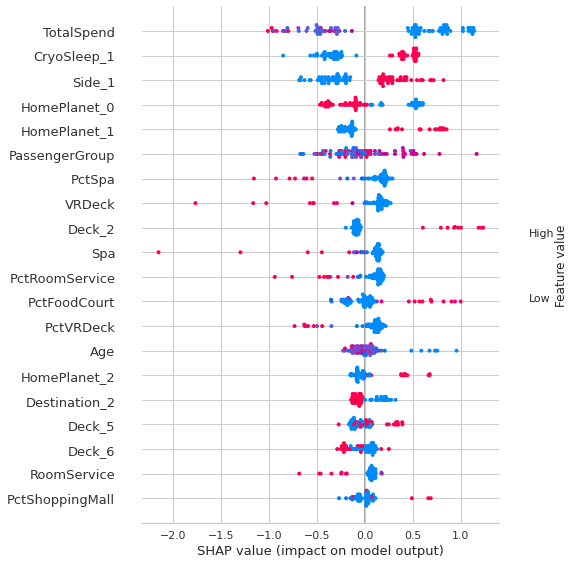

In [51]:
interpret_model(catboost_best)

In [52]:
submission['Transported'] = y_pred
submission.to_csv('submission.csv', index=False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
